In [1]:
######################################
# DEPENDENCIES
######################################
import os
import math
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


## The Data
From the __[NASA Exoplanet archive](https://exoplanetarchive.ipac.caltech.edu/index.html)__, we have retrieved 3 data tables:
 - A table storing information relating to each exoplanet & its planetary system
 - A table storing information relating to the transit spectroscopy of exoplanet
 - A table storing information relating to the emission spectroscopy of exoplanet


In [2]:
# represents all data, including data points with missing features
# total data = pd.read_csv('...')
# Select the features which are most abundant?

#Raw Data Tables
# change this to perfectly filled out data only, with relevant 11 
# features (for the non-vital features, choose most abundant)
systems_df = pd.read_csv('data/PS_2021.12.02_11.43.14.csv', sep=',', low_memory=False)

transitspec_df = pd.read_csv('data/transitspec_2021.10.21_17.04.26.csv', sep=',', low_memory=False)

emispec_df = pd.read_csv('data/emissionspec_2021.10.22_13.36.00.csv', sep=',', low_memory=False)

## Discovery Method
The most important and generalized information is stored in the "Planetary Systems" database, which we will be calling _systems_df_. This is general information about the discovery of the planets, what system they are from, and the most pertinant information about the exoplanet and system.

Notice that in this table, we have included the 'discovery method' column, as this is relevant to the interpretation of all other features. Particularly, notice that there is associated with the plantary mass a 'provenance', which indicates wether or not a planet's mass is given as a "True Mass" or as a lower bound on planetary mass, depending on the discovery method. 

We will stratify the data by its method of discovery, so that meaningful comparisons can be made between rows. One of the most common and successful discovery methods is the transit method, which refers to observations of a planet which passes directly in between it's host star and the viewer, altering the observed light effects:

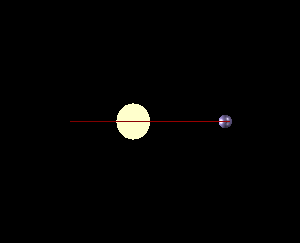

(image in public domain)

We will start by working on the data obtained by this method, and then move on to other popular methods such as Radial Velocity, Direct Imaging, or Microlensing. 



## General Purpose
- Create a program which can interpret a mixture of planetary and stellar data to classify planets into the categories of habitable and not habitable, based on pre-existing definitions garnered from what has been studies about life on Earth.
(The obvious problem with this model is that we know so little about life elsewhere in the cosmos.)

## Habitability Classification
In the preprocessing stage of our investigation, we shall determine the planets which fall within the following bounds to be "habitable." Planets which fail to meet any of these parameters will be considered not habitable.

Stellar Characteristics:
- Stellar Mass: 0.4 to 1.4 times the Sun’s mass 
- Types of habitable stars
    - Late F, G, to mid
- Temperature: Between 3000 and 7000 K
- Using Luminosity to determine habitable zone 
    - ri = √Lstar/1.1 (inner boundary of habitable zone)
    - r0 = √Lstar/0.53 (outer boundary of habitable zone)
    - link: https://www.planetarybiology.com/calculating_habitable_zone.html
- Than, based on these bounds, if orbit semi-major axis falls outside of these zones, not habitable
- Stellar Age: Stars formed between 11 and 3.8 billion years ago
    - Thus, valid age range lies between 3.8 and 11 billion years old
   

- Stellar Metallicity
    - Strongly affects the duration of the habitable zone, and the distance from the host star where duration is maximized 
    - General rule: Stars having significantly high-than-solar metallicity have a much longer duration of habitability at a given distance than do stars of lower-than-solar metallicity. Heavy elements are required for life to emerge, and stars without heavy metal presence were likely formed in the primordial stages of the universe. 
    - For a 1.0 M star (mass of the sun) w/ solar metallicity of 0.017 duration of habitable zone lasts for less than 10 billion years at 1.2 to 2.0 AU from the star
    - Duration is greater than 20 billion years for high-metallicity stars (0.070) at distances 0.7-1.8 AU
    - ~4 Billion years at distances of 1.8-3.3 AU for low-metallicity stars (0.0001)  
    - Paper: https://iopscience.iop.org/article/10.1088/0004-637X/769/1/27/pdf
    - We are already using the above equations to determine our "habitable" zones
    - As such, we will primarily use metallicity to characterize duration.
    - The characterization for metallicities effects depends widely on the other parameters, including stellar age, distance, and semi-major orbital axis. As such, for the purpose of this classification, stars that fall below the metallicity of 0 will be ruled as inhabitable. Any lower of a ratio would result in a lack of heavy elements sufficient to support complex biological structures. 
 


Planetary Characteristics
Orbital Eccentricity (a less certain parameter)
- Habitability model refers to obliquity, spin rate, orbital    eccentricity, and fraction of the surface covered by ocean
- Since so few of the planets have statistics for obliquity (true or projected) eccentricity is veritably useless)
- (DISREGARD ECCENTRICITY)
- Equilibrium Temperature (no real known bounds on habitability)
- (HOWEVER, could classification find relationships? Include as features anyways?)

- Planetary Mass:
    - Must be at least 2.7 percent mass of Earth
    - Paper: https://iopscience.iop.org/article/10.3847/1538-4357/ab2bf2
    - Any smaller than 2.7 percent, and the planet will not be able to hold onto its atmosphere and water long enough for life to appear
    - Upper bound on Planetary mass: 5 𝑀⊕ (earth masses)

    

  


In [3]:
#ASK: what are the MOST ESSENTIAL features?
for col in systems_df.columns:
    print(col)


pl_name
hostname
default_flag
sy_snum
sy_pnum
discoverymethod
pl_controv_flag
pl_orbper
pl_orbsmax
pl_rade
pl_radj
pl_bmasse
pl_bmassprov
pl_orbeccen
pl_insol
pl_eqt
ttv_flag
st_spectype
st_teff
st_rad
st_mass
st_met
st_metratio
st_logg
rastr
ra
decstr
dec
sy_dist
sy_vmag
sy_kmag
sy_gaiamag


## Strata

In [4]:

#To avoid controversy, remove rows with nonzero 'controversial' flag
systems_df = systems_df[systems_df['pl_controv_flag'] == 0]
"""
#***
#stratify by method, as described above.
total_default = len(systems_df[systems_df['default_flag']==1])
print(f"total number of \'default readings\': {total_default}\n")

pl_systems_transit = systems_df[systems_df['discoverymethod'] == 'Transit']
print(f"num rows by Transit method: {len(pl_systems_transit)}")
print(f"% default: {len(pl_systems_transit[pl_systems_transit['default_flag'] == 1])/len(pl_systems_transit)}")
print(f"% of total default: {len(pl_systems_transit[pl_systems_transit['default_flag'] == 1])/total_default}\n")

pl_systems_radial = systems_df[systems_df['discoverymethod'] == 'Radial Velocity']
print(f"num rows by Radial Velocity method: {len(pl_systems_radial)}")
print(f"% default: {len(pl_systems_radial[pl_systems_radial['default_flag'] == 1])/len(pl_systems_radial)}")
print(f"% of total default: {len(pl_systems_radial[pl_systems_radial['default_flag'] == 1])/total_default}\n")

pl_systems_img = systems_df[systems_df['discoverymethod'] == 'Imaging']
print(f"num rows by Direct Imaging method: {len(pl_systems_img)}")
print(f"% default: {len(pl_systems_img[pl_systems_img['default_flag'] == 1])/len(pl_systems_img)}")
print(f"% of total default: {len(pl_systems_img[pl_systems_img['default_flag'] == 1])/total_default}\n")

pl_systems_microlens = systems_df[systems_df['discoverymethod'] == 'Microlensing']
print(f"num rows by Microlensing method: {len(pl_systems_microlens)}")
print(f"% default: {len(pl_systems_microlens[pl_systems_microlens['default_flag'] == 1])/len(pl_systems_microlens)}")
print(f"% of total default: {len(pl_systems_microlens[pl_systems_microlens['default_flag'] == 1])/total_default}\n")

pl_systems_eclipse = systems_df[systems_df['discoverymethod'] == 'Eclipse Timing Variations']
print(f"num rows by Eclipse Timing method: {len(pl_systems_eclipse)}")
print(f"% default: {len(pl_systems_eclipse[pl_systems_eclipse['default_flag'] == 1])/len(pl_systems_eclipse)}")
print(f"% of total default: {len(pl_systems_eclipse[pl_systems_eclipse['default_flag'] == 1])/total_default}\n")

#***
"""

pl_names = systems_df['pl_name']
host_names = systems_df['hostname']

## Preprocessing (determining our "habitable" and not "habitable" planets
- Impute missing data?


As we can see from the above calculations, the Transit method is the most common and popular, yet the least reliable, going by the readings which are flagged as 'default' for that particular exoplanet. On the other hand, Radial velocity, though less reliable than Direct Imaging, has a good amount of default readings, and also has a higher amount of features.

## Creating Training Data (partitioning table based on defined parameters)

In [6]:
# Bounds for Habitable Planet:

# If the semi-major orbital axis takes the planet beyond these zones,
# we will not classify the planet as habitable.

# represents the systems data that has luminosity values
systems_df_3 = systems_df[systems_df['st_logg'].notnull()]

# Stellar mass: 0.4 < x < 1.4 (in Sun masses)
systems_df_4 = systems_df_3[systems_df_3['st_mass'] > 0.4]
systems_df_5 = systems_df_4[systems_df_4['st_mass'] < 1.4]

# Luminosity (will be used in the following calculation)
# ri = √Lstar/1.1 (inner boundary of habitable zone)
# r0 = √Lstar/0.53 (outer boundary)
systems_inner_bound = systems_df_5['st_logg']/1.1 ** 1/2
systems_outer_bound = systems_df_5['st_logg']/0.53 ** 1/2
# now, we have to ensure that the semi-major orbital axis
# falls within thse parameters to find the "habitable" planets
# orbsmax
# valid_semi_major
valid_orbit = systems_df_5[(systems_df_5['pl_orbsmax'] > systems_inner_bound)&(systems_df_5['pl_orbsmax'] < systems_outer_bound)]

print(valid_orbit)

# When it falls between these age ranges
# (need to add to dataframe)
# Stellar Age: between 3.8 and 11 billion years old
valid_age = valid_orbit[(valid_orbit['st_age'] > 3.8) & (valid_orbit['st_age'] > 3.8)]
print(len(valid_age))

# stellar metallicity: greater than 0
# the bound that we are accepting as the range of habitability
valid_metallicity = valid_age[(valid_age['st_met'] > 0)]

# planet mass: between 0.0257 Earth Masses and 5 Earth Masses
valid_mass = valid_metallicity[(valid_mettalicity['pl_bmasse'] > 0.257)& (valid_mettalicity['pl_bmasse'] < 5)]

# reupload the table with only the filled in values, missing values
# must be imputed. So systems_df_3 takes from perfect table
systems_not_habitable = systems_df_3.sub(valid_mass)

# We then divide these features into training and test data
# We take random subset of positive answers, and we label them
# as x training data

x_train_habitable = valid_mass.sample(n=(len(valid_mass)*(2/3)))
x_train_unhabitable = systems_not_habitable.sample(n=len(systems_not_habitable) * 2/3)
y_train_habitable = np.ones(len(x_train))
y_train_uninhabitable = np.zeros(len(x_train_uninhabitable))

# we take the exclusive subset of the training data as the test data
x_test_habitable = valid_mass.sub(x_train)
y_test_habitable = np.ones(len(x_test))
x_test_uninhabitable = systems_not_habitable.sub(x_test_habitable)
y_test_uninhabitable = np.zeros(x_test_uninhabitable)

# Arguement for validity of features will be above

# then, we use imputation
# (USING OUR EXISTING FEATURES TO "IMPUTE" THE BLANK FEATURES)
# Method of imputation:
# so we can assume the data frame to impute 
# this is where the variational autoencoder works, on the missing data
#to_process = total_systems.sub(systems_df_3)

# transform the data into small batch of features (dimensionality reduction)
# and transform back into larger dimensionality



















         pl_name hostname  default_flag  sy_snum  sy_pnum  discoverymethod  \
7       14 Her b   14 Her             0        1        2  Radial Velocity   
9       14 Her b   14 Her             0        1        2  Radial Velocity   
12      14 Her b   14 Her             1        1        2  Radial Velocity   
13      14 Her b   14 Her             0        1        2  Radial Velocity   
20      17 Sco b   17 Sco             1        1        1  Radial Velocity   
...          ...      ...           ...      ...      ...              ...   
29534  eps Eri b  eps Eri             0        1        1  Radial Velocity   
29548  iot Dra b  iot Dra             0        1        1  Radial Velocity   
29603  ups And d  ups And             0        2        3  Radial Velocity   
29606  ups And d  ups And             0        2        3  Radial Velocity   
29607  ups And d  ups And             0        2        3  Radial Velocity   

       pl_controv_flag   pl_orbper  pl_orbsmax  pl_rade  ...  s

KeyError: 'st_age'

## The data collected w/o imputation
This data is coalesced without imputation.

## Spectral Types
one of the features that will be important to us is the spectral type of the exoplanet. As the name implies, this refers to the type of star which the planet is in orbit of. You can read more about the Morgan-Keenan system of spectral classification __[here](https://astronomy.swin.edu.au/cosmos/m/morgan-keenan+luminosity+class)__ and about the Harvard Spectral Classification __[here](https://astronomy.swin.edu.au/cosmos/H/Harvard+Spectral+Classification)__, but essentially, the lower the numeral, the more massive and luminous the star is. Both of these attributes are tracked on their own in the main table, but stratifying on this feature attribute may also be informative.

In [ ]:
mk_types = ['Ia-O', 'Ia', 'Ib', 'II', 'III', 'IV',  'V', 'VI' 'D']
#H_types
for spec_t in pl_systems_img['st_spectype']: print(spec_t) 
#Let's see how many of each type we have

## Imputation
Because this dataset contains a significant amount of missing values, we will experiment with imputing the missing values, in order to avoid throwing away whole planet rows.

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imp = IterativeImputer(max_iter=100, n_nearest_features= imputation_order='ascending', random_state=0, add_indicator=True)



## Our Solar System

There is actually one datapoint that we can confidently label as 'habitable' and that is our home system of the sun, and our home planet of earth. Once we have discovered the underlying distribution of all other exoplanet systems, this information may be used to create a discrete classification for exoplanets that seem to be in a similar ballpark.

In [ ]:

#extract the stellar features of highest importance from this table
# - Host Star Name (optional)
# - Stellar Mass
# - Stellar Metallicity
# - Stellar Effective temperature
starinfo_df = systems_df[['st_mass', 'st_met', 'st_teff']]

#define these same features for our sun (source: Wikipedia)
SUN_MASS = 1
SUN_MET = 0.0122
SUN_TEFF = 5772

m_sun = np.array([SUN_MASS,
                 SUN_MET,
                 SUN_TEFF])


## Defining 'Habitability'
Notice that this data is unlabeled. This means that most of the techniques that we have employed in this course thus far will not be applicable immediately, as we are not able to regress or classify based on some underlying mapping between between our input space of data, and an output space of labellings. 

We are left with a choice between two options. We could:
 - A -- Manually create labellings for our data points, either by hand or by some iterative approach,
  or
 - B -- Employ statistical learning models that do not require labellings in order to build our understanding from the ground up, and then create class labellings from the 

This is justified not only by the present relevance of such methods in the field, but by the fact that had we taken approach A, our learning model would merely be seeking to mimic whatever function we use to label the data. Once we have explored these methods of dimensionality reduction, it may be possible to apply discrete class labellings to the data in a more meaningful way.

# TODO: Insert scientific notion of habitability -- provide sources

## Gaussian Mean and Variance

In [ ]:
starinfo_x = starinfo_df.dropna()
#The line above is somewhat problematic due to the erasure of some potentially valid data

starinfo_mean = starinfo_x.mean();

print("mean vector of stellar features:\n {0} \n".format(starinfo_mean))

print("covariance of key stellar features")
cov_X = starinfo_x.cov()
print(cov_X)

print("\ncorrelation of key stellar features")
corr_X = starinfo_x.corr()
print(corr_X)

print(starinfo_x)

In [ ]:
#####################################################
#DEFINE INPUT SPACE
#####################################################

X = starinfo_x.to_numpy()
print (X.shape)
print(X)


In [ ]:
from sklearn.decomposition import KernelPCA, FactorAnalysis

## Kernel PCA
The next step will be to try to use simple generative linear models to obtain insights on the nature of the data. We will start by performing principal component analysis with a selection of various common kernel functions.

In [ ]:
#PCA

kpca = KernelPCA(n_components=2, kernel='linear') 
kpca.fit(X);
X_kpca = kpca.transform(X)

print(f"Latent space from PCA, linear kernel: \n{X_kpca}\n")

plt.title('2d PCA w/ linear kernel')
plt.scatter(X_kpca[:,0], X_kpca[:,1])
plt.show()

kpca = KernelPCA(n_components=2, kernel='poly', degree=3) #increasing degree of poly kernel seems to reduce variance.
kpca.fit(X);
X_kpca = kpca.transform(X)

print(f"Latent space from PCA, polynomial kernel: \n{X_kpca}\n")

plt.title('2d PCA w/ cubic kernel')
plt.scatter(X_kpca[:,0], X_kpca[:,1])
plt.show()

kpca = KernelPCA(n_components=2, kernel='rbf') 
kpca.fit(X);
X_kpca = kpca.transform(X)

print(f"Latent space from PCA, rbf kernel: \n{X_kpca}\n")

plt.title('2d PCA w/ rbf kernel')
plt.scatter(X_kpca[:,0], X_kpca[:,1])
plt.show()


kpca = KernelPCA(n_components=2, kernel='cosine') 
kpca.fit(X);
X_kpca = kpca.transform(X)

print(f"Latent space from PCA, cosine kernel: \n{X_kpca}\n")

plt.title('2d PCA w/ cosine kernel')
plt.scatter(X_kpca[:,0], X_kpca[:,1])
plt.show()

In [ ]:
#we need to extract classes or habitability metric in a deterministic fashion from this data.
#Do this using multivariate Gaussian distribution centered around sun data.
                                                                   
#gaussian: (mean vector, cov matrix) -> (num -> prob)
def gaussian(mu, sig):
    return lambda x : (1 / (2 * PI * np.linalg.det(sig))**(1/2)) * np.exp(-1/2 * np.transpose(np.subtract(x, mu)) * np.linalg.inv(sig) * np.subtract(x,mu))


sun_likeness = gaussian(m_sun, corr_X)



In [ ]:
from sklearn.cluster import KMeans

